## Практическое задание к курсу

<ol>
    <li>Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.</li>
    <li>Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике? 
    </li>


</ol>

## TGS Salt Identification Challenge
#### Segment salt deposits beneath the Earth's surface

https://www.kaggle.com/c/tgs-salt-identification-challenge

Several areas of Earth with large accumulations of oil and gas also have huge deposits of salt below the surface.

But unfortunately, knowing where large salt deposits are precisely is very difficult. Professional seismic imaging still requires expert human interpretation of salt bodies. This leads to very subjective, highly variable renderings. More alarmingly, it leads to potentially dangerous situations for oil and gas company drillers.

To create the most accurate seismic images and 3D renderings, TGS (the world’s leading geoscience data company) is hoping Kaggle’s machine learning community will be able to build an algorithm that automatically and accurately identifies if a subsurface target is salt or not.

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
im_width = 128
im_height = 128
border = 5
path_train = './input/train/'
path_test = './input/test/'

In [3]:
def get_data(path, train=True):
    ids = next(os.walk(path + "images"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        img = load_img(path + '/images/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

        if train:
            mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)

Getting and resizing images ... 


/Users/user/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/Users/user/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done!


In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

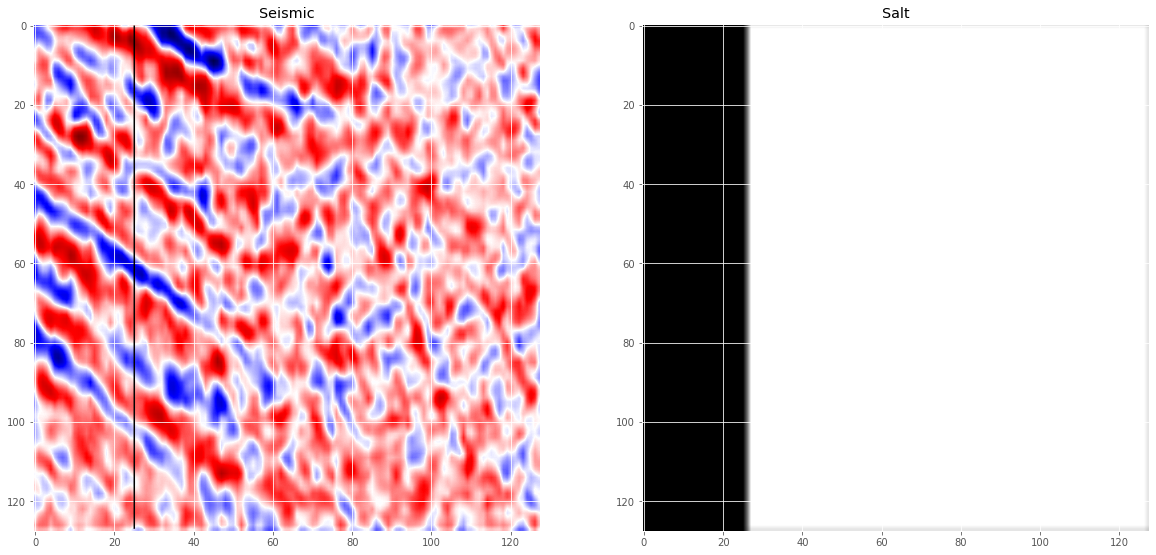

In [5]:
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

In [6]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [7]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [8]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [9]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [10]:
results = model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 2800 samples, validate on 1200 samples
Epoch 1/10
2800/2800 [==============================] - 191s 68ms/step - loss: -156.9984 - accuracy: 0.4976 - val_loss: -885.9909 - val_accuracy: 0.2046

Epoch 00001: val_loss improved from inf to -885.99089, saving model to model-tgs-salt.h5
Epoch 2/10
2800/2800 [==============================] - 185s 66ms/step - loss: -290.0704 - accuracy: 0.1188 - val_loss: -868.4729 - val_accuracy: 0.3742

Epoch 00002: val_loss did not improve from -885.99089
Epoch 3/10
2800/2800 [==============================] - 185s 66ms/step - loss: -424.2724 - accuracy: 0.0902 - val_loss: -2046.8761 - val_accuracy: 0.2054

Epoch 00003: val_loss improved from -885.99089 to -2046.87615, saving model to model-tgs-salt.h5
Epoch 4/10
2800/2800 [==============================] - 185s 66ms/step - loss: -585.1926 - accuracy: 0.0876 - val_loss: -1663.8697 - val_accuracy: 0.4514

Epoch 00004: val_loss did not improve from -2046.87615
Epoch 5/10
2800/2800 [=================

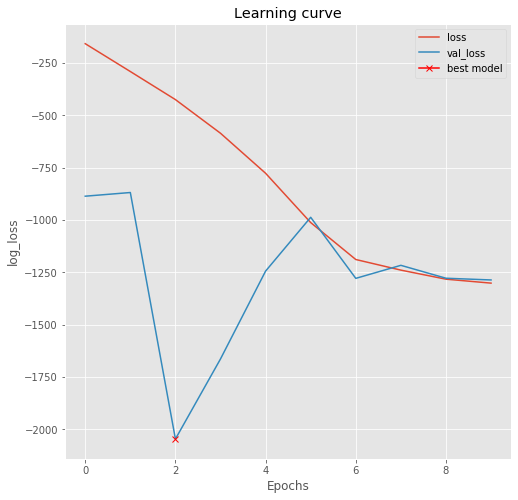

In [11]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [12]:
model.load_weights('model-tgs-salt.h5')

In [13]:
model.evaluate(X_valid, y_valid, verbose=1)

1200/1200 [==============================] - 18s 15ms/step


[-2046.8761458333333, 0.20544610917568207]

In [14]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

1200/1200 [==============================] - 18s 15ms/step


In [15]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

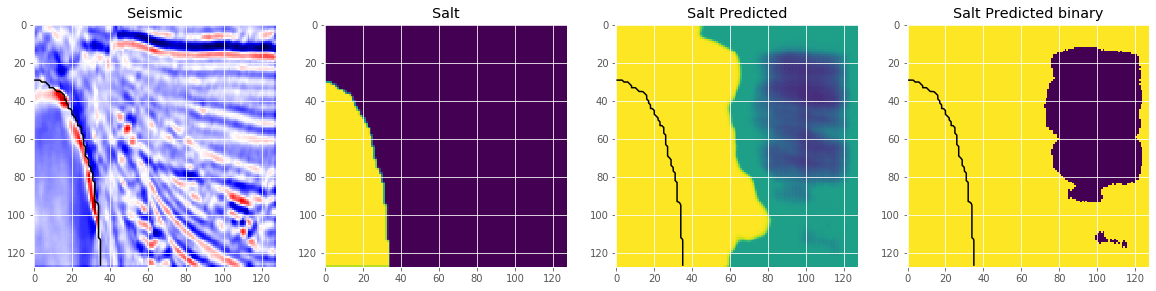

In [16]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

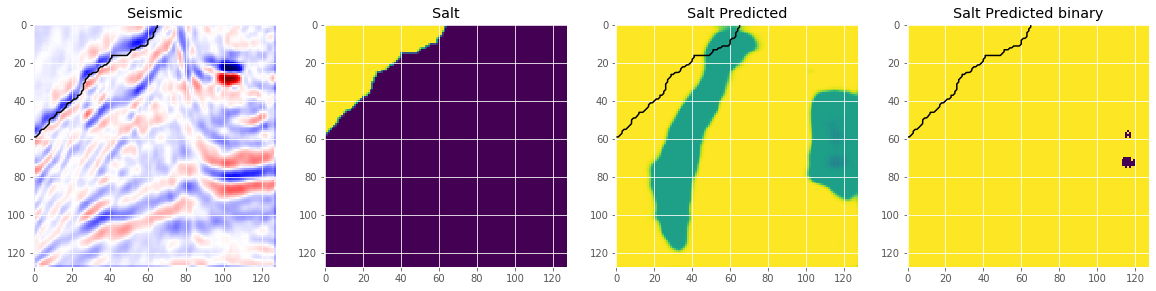

In [17]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

In [18]:
# Обучили UNet на датасете TGS Salt
# качество результатов пока что оставляетс желать лучшего
# для дальнейшего улучшения можно попробовать поменять количество эпох и изменить batch size
# также можно увеличить долю train объектов